# 応用情報工学演習（谷口研）グループ課題

毒キノコかどうかを判断する識別器の構築。

共通関数は、自由に利用しても問題ありません。


In [ ]:
# 必要ライブラリ・コマンドの導入

w = !apt install tree
print(w[-2])

In [ ]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm
from turtle import shape

# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import models


# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [ ]:
# GPUチェック
# "cuda:0" if torch.cuda.is_available() else
device = torch.device("cpu")
print(device)

**共通関数の読み込み**

In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc.cpu(), avg_val_loss, avg_val_acc.cpu()])
        history = np.vstack((history, item))
    return history

# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'[初期状態] loss: {history[0,3]:.5f}, accuracy: {history[0,4]:.5f}')
    print(f'[最終状態] loss: {history[-1,3]:.5f}, accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='training')
    plt.plot(history[:,0], history[:,3], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve (loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='training')
    plt.plot(history[:,0], history[:,4], 'k', label='validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning curve (accuracy)')
    plt.legend()
    plt.show()

# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## データ準備

[URL](https://www.robots.ox.ac.uk/~vgg/data/pets/)からファイルをダウンロードして、Google Colabへアップロードすることもできますが、Google Colabのランタイムがリセットされるたびにアップロードが必要なため、
コマンドでダウンロードと解凍ができるようにしておきます。

### サンプルデータのダウンロード・解凍

In [ ]:
# データ解凍
w = !unzip -n mushroom.zip
print(w[-1])

  inflating: __MACOSX/mushroom/._ce (394).jpg  


In [ ]:
# 解凍ファイルのtree表示
!tree mushroom

mushroom
├── ce (100).jpg
├── ce (101).jpg
├── ce (102).jpg
├── ce (103).jpg
├── ce (104).jpg
├── ce (105).jpg
├── ce (106).jpg
├── ce (107).jpg
├── ce (108).jpg
├── ce (109).jpg
├── ce (10).jpg
├── ce (110).jpg
├── ce (111).jpg
├── ce (112).jpg
├── ce (113).jpg
├── ce (114).jpg
├── ce (115).jpg
├── ce (116).jpg
├── ce (117).jpg
├── ce (118).jpg
├── ce (119).jpg
├── ce (11).jpg
├── ce (120).jpg
├── ce (121).jpg
├── ce (122).jpg
├── ce (123).jpg
├── ce (124).jpg
├── ce (125).jpg
├── ce (126).jpg
├── ce (127).jpg
├── ce (128).jpg
├── ce (129).jpg
├── ce (12).jpg
├── ce (130).jpg
├── ce (131).jpg
├── ce (132).jpg
├── ce (133).jpg
├── ce (134).jpg
├── ce (135).jpg
├── ce (136).jpg
├── ce (137).jpg
├── ce (138).jpg
├── ce (139).jpg
├── ce (13).jpg
├── ce (140).jpg
├── ce (141).jpg
├── ce (142).jpg
├── ce (143).jpg
├── ce (144).jpg
├── ce (145).jpg
├── ce (146).jpg
├── ce (147).jpg
├── ce (148).jpg
├── ce (149).jpg
├── ce (14).jpg
├── ce (150).jpg
├── ce (151).jpg
├── ce (152).jpg
├── ce (15

## <課題>

課題ファイル（LETSU参照）を利用して、「イヌ」と「ネコ」を識別する識別器を作成して下さい。最終的には、精度を計算し、正解した画像と間違えた画像をそれぞれ列挙します。  
このとき利用するデータは、学習で利用していない画像（評価用画像）を使ってください。  
50件を超える場合は、50件だけ表示を行います。各画像の上には、「正解データラベル」：「識別器の予測ラベル」の順でラベルを表示してください。  
両者が異なる場合は、分かりやすく色を付けます。以下のステップを参考にして、課題を行ってください。

識別器（ネットワーク）は、深層学習ベースのものであれば、特に指定はありません。  
自分でゼロから、もしくはファインチューニングや転移学習を利用して作成することができます。  
ネットワーク構造やオプティマイザなど、どうしてそのようなものを選んだか分かりやすいように、コメントで解説を入れてください。

※上記の共通関数は自由に使ってください。

## STEP1 データの読み込みと前処理

データの前処理を行います。ダウンロードしたファイルには、「images」という名前のフォルダに「イヌ」と「ネコ」の画像が入っています。  
画像はそれぞれ異なったサイズです。

また、「list.csv」というファイルが入っています。  
これはアノテーションデータと呼び、画像のファイル名や「イヌ」や「ネコ」の品種情報などが入っています。  
データフォーマットは、CSVファイルになっており、各項目は表1の通りです。

表1　アノテーションファイルの見出しについて

| 列   | 見出し       | 説明                       |
|-----|-----------|--------------------------|
| 1列目 | Image     | 画像のファイル名（拡張子無し）。         |
| 2列目 | CLASS\-ID | クラスID（1\-37：イヌとネコ合わせて）。  |
| 3列目 | SPECIES   | イヌかネコかのID（1：ネコ、2：イヌ）。    |
| 4列目 | BREED\-ID | 品種ID（1\-25：イヌ、1\-12：ネコ）。 |


まずは、アノテーションファイルを読み込み、ファイル名と「イヌ」か「ネコ」のラベルを読み込みます。  
CSVファイルの読み込みには、Pandas ([公式ドキュメント](https://pandas.pydata.org/docs/index.html))が利用できます。

PyTorchで自作のデータセットを扱う方法は、いくつかありますが、ここではDatasetクラスを継承したクラスを利用する方法を紹介します。  
この方法では、Datasetクラスを継承し、特殊メゾットである「`__len__`」と「`__getitem__`」をオーバーライドします。「`__len__`」は、データセットの長さを返すように実装し、「`__getitem__`」は、インデックスを表す引数「`pos`」で与えられたデータを返すように実装します（下記のソースコード参照）。  
また、[`__init__`]関数内で、入力するネットワークに合わせて画像を加工します。

転移学習やファインチューニングを利用する場合は、PyTorchでは224×224画素に統一する必要があります。  
画像加工には`Transforms`を利用できます。  
例として、画像のリサイズには[transforms.Resize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)、画像のクロッピングには[transforms.CenterCrop](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.CenterCrop)が利用できます。

また、訓練データにはデータ拡張を適用しましょう。




### アノテーションデータ読み込み

In [ ]:
# データがあるディレクトリ
DATA_DIR = 'mushroom'

# アノテーションデータ（データセットの定義ファイル）を読み込む
df = pd.read_csv(os.path.join(DATA_DIR, 'list.csv'))

# 分類先クラスのリスト作成
classes = ['no', 'yes']

# データとクラスラベルに分割
# クラスラベルは0から始まるようにする
file, label = df.Image.tolist(), [i - 1 for i in df.SPECIES.tolist()]

データを学習用と評価用に分けるために、scikit-learnの`train_test_split`関数を利用します。  
通常、学習用と評価用のデータは、クラスIDの比率（ココでは「イヌ」と「ネコ」の比率）を保ったまま分割することが望ましいです。  
また、学習用と評価用のデータは7：3程度の割合で分割を行います。  
`train_test_split`は、クラスIDの比率を保ったまま、任意の比率にデータを分割することができます。  
詳しくは、[公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)を参照してください。

In [ ]:
# シーン毎に学習用と評価用データに分ける
train_X, test_X, train_y, test_y = train_test_split(file, label, test_size=0.3, random_state=0)

### データセット定義

自作のデータセット用のDataset クラスを継承したクラス例は以下の通りです。


In [ ]:
# データセットをクラスで定義する
class MyDataset(Dataset):
    def __init__(self, X, y, valid=False):
        # 初期化 Xはファイル名のリスト、yはネコかイヌかのリスト
        self.X = X
        self.y = y
        if not valid: # 学習用ならDAを含んだtransoformを作る
            trans = [
                # 画像のリサイズなどの前処理&データ拡張を追加する
                transforms.Resize((224, 224)), # 画像全体を 224×224 画素に変換,
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.5)
            ]
        else: # 評価時にはDAを含まないtransoformを作る
            trans = [
                # 画像のリサイズなどの前処理
                transforms.Resize((224, 224)), # 画像全体を 224×224 画素に変換
                transforms.ToTensor()
            ]
        self.trans = transforms.Compose(trans)

    def __len__(self):
        # データセットの長さを返す
        return len(self.X)

    def __getitem__(self, pos):
        # posの場所にあるデータを返す
        f = os.path.join(DATA_DIR, self.X[pos]) # ファイルパス
        X = Image.open(f).convert('RGB') # ファイルを読み込む
        X = self.trans(X) # DAしてtensorにする
        y = self.y[pos]
        return X, y

In [ ]:
# 訓練用
from operator import truediv
from pickle import TRUE

# 学習用
train_data = MyDataset(train_X, train_y)

# 検証用
test_data = MyDataset(test_X, test_y, True)

In [ ]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 1076件
検証データ: 462件


## STEP2 データ確認

学習データと評価データそれぞれ最初の10個と最後の10個を表示する。  
データ拡張などが期待通りに適用されているか確認する。  

例：

* 学習データ

ここでは`transforms.RandomErasing()`により画像の一部をランダムに消すデータ拡張を適用しています。

![画像出力例](https://drive.google.com/uc?export=view&id=15mQFhvgrBWHDPt_xxnQgVlIGgrrbXbUp)

* 訓練データ

![画像出力例](https://drive.google.com/uc?export=view&id=18-oRM9IXPen1Z9k55HCNhmZuS5JLzm3N)

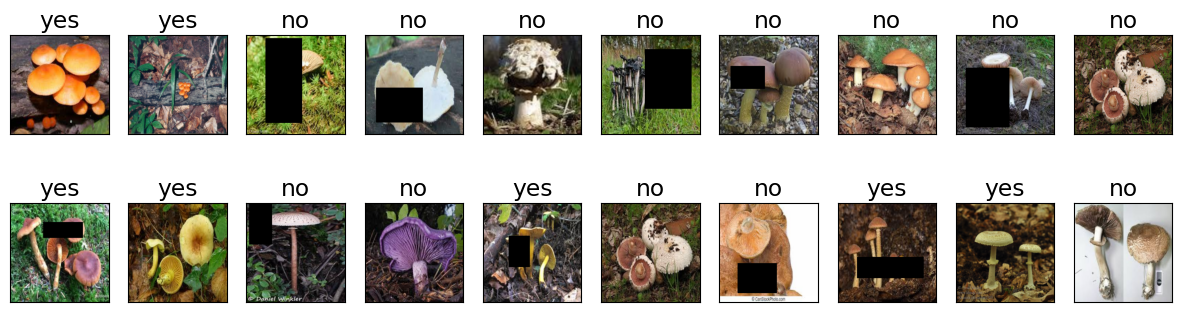

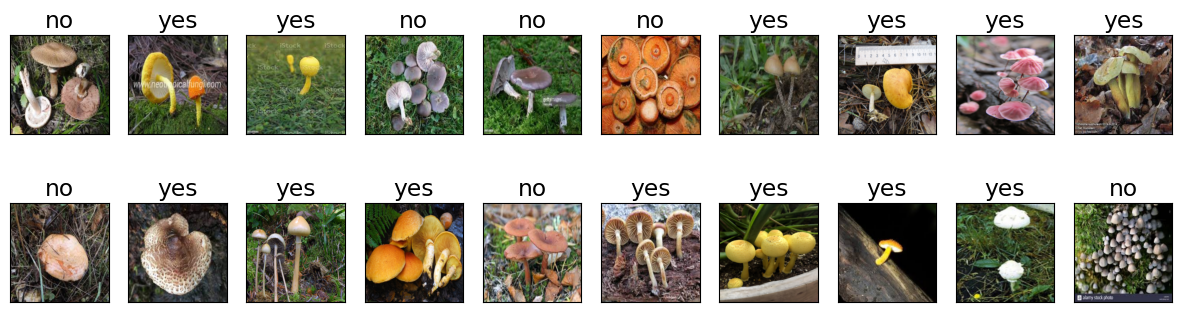

In [ ]:
# 学習データと訓練データの最初の10個と最後の10個を表示

def show_head_and_tail(data):
    plt.figure(figsize=(15, 4))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        image, label = data[i]# dataを前から読み出す
        image_np = image.numpy().copy()
        img = np.transpose(image_np, (1, 2, 0)) # 軸の修正 & 値の範囲修正
        plt.imshow(img)
        ax.set_title(classes[label])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, 10, i + 11)
        image, label = data[-1-i]# dataを後ろから読み出す
        image_np = image.numpy().copy()
        img = np.transpose(image_np, (1, 2, 0)) # 軸の修正 & 値の範囲修正
        plt.imshow(img)
        ax.set_title(classes[label])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

show_head_and_tail(train_data)
show_head_and_tail(test_data)


## STEP3 ミニバッチ作成

In [ ]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(
    train_data, batch_size = batch_size,
    shuffle = True)

# 検証用
test_loader = DataLoader(
    test_data, batch_size = batch_size,
    shuffle = False)


## STEP4 モデル定義

In [ ]:

# 学習モデル定義
net = models.resnet18(pretrained = True)

# 乱数初期化
torch_seed()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.8MB/s]


## STEP5 学習

In [ ]:
# historyファイルも同時に初期化する
history = np.zeros((0, 5))

# 学習
num_epochs = 10

history = fit(net, optimizer, criterion, num_epochs,
        train_loader, test_loader, device, history)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.12921 acc: 0.62546 val_loss: 0.06021, val_acc: 0.73160


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.04610 acc: 0.80669 val_loss: 0.11419, val_acc: 0.60606


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.03312 acc: 0.86617 val_loss: 0.05572, val_acc: 0.78139


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.01871 acc: 0.91450 val_loss: 0.05701, val_acc: 0.77706


  0%|          | 0/108 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.01579 acc: 0.93123 val_loss: 0.05633, val_acc: 0.81602


  0%|          | 0/108 [00:00<?, ?it/s]

[初期状態] loss: 0.05339, accuracy: 0.82035
[最終状態] loss: 0.06500, accuracy: 0.81818


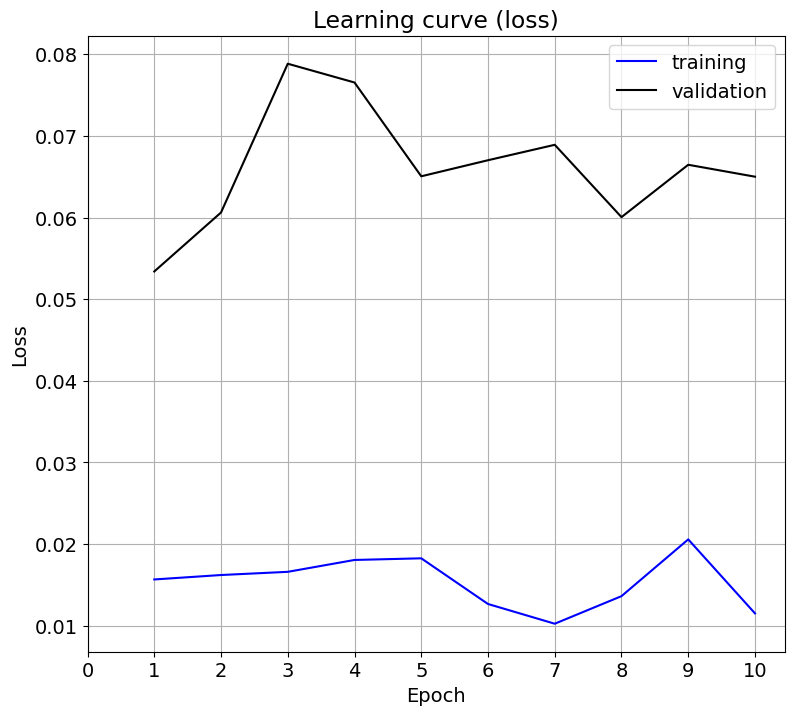

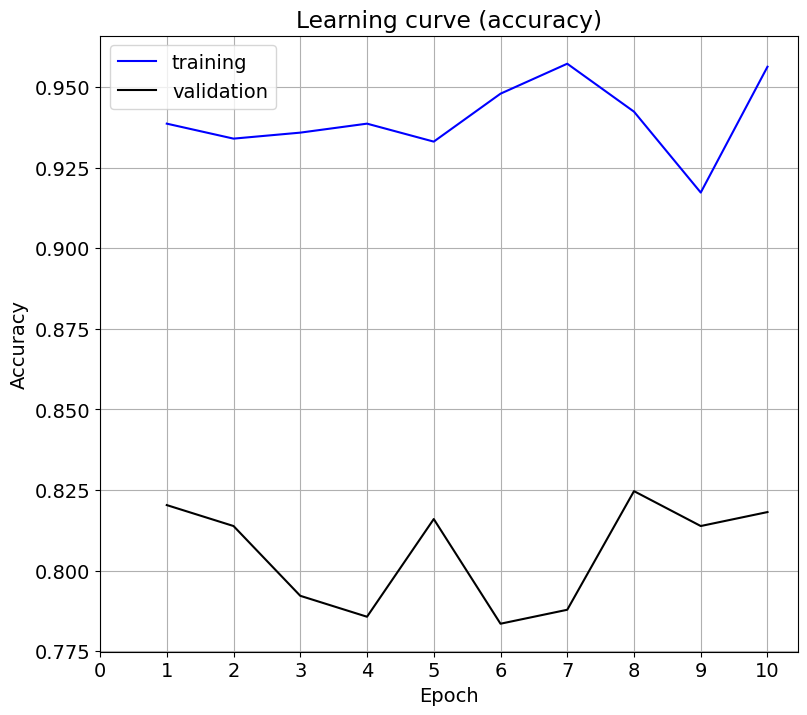

In [ ]:
# 結果確認
evaluate_history(history)

In [ ]:
# イメージとラベル表示

def show_images_labels(loader, classes, net, device):
    truelen = []
    falselen = []
    x = []
    y = []
    z = []
    w = []

    for images, labels in loader:
        if net is not None:
          # デバイスの割り当て
          inputs = images.to(device)
          labels = labels.to(device)

          # 予測計算
          outputs = net(inputs)
          predicted = torch.max(outputs,1)[1]

          for i in range(len(labels)):
            label_name = classes[labels[i]]
            predicted_name = classes[predicted[i]]
            if label_name == predicted_name:
              truelen.append(images[i])
              x.append(label_name)
              y.append(predicted_name)
            else:
              falselen.append(images[i])
              z.append(label_name)
              w.append(predicted_name)

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))

    for i in range(min(len(truelen), 50)):
      ax = plt.subplot(10, 10, i+1)
      # 正解かどうかで色分けをする
      c = 'k'
      ax.set_title(x[i] + ':' + y[i], c=c, fontsize=15)
      image_np = truelen[i].numpy().copy()
      # 軸の順番変更 (channel, row, column) -> (row, column, channel)
      img = np.transpose(image_np, (1, 2, 0))
      # 値の範囲を[-1, 1] -> [0, 1]に戻す
      img = (img + 1)/2
      # 結果表示
      plt.imshow(img)
      ax.set_axis_off()

    for i in range(min(len(falselen), 50)):
      ax = plt.subplot(10, 10, i+51)
      # 正解かどうかで色分けをする
      c = 'b'
      ax.set_title(z[i] + ':' + w[i], c=c, fontsize=15)
      image_np = falselen[i].numpy().copy()
      # 軸の順番変更 (channel, row, column) -> (row, column, channel)
      img = np.transpose(image_np, (1, 2, 0))
      # 値の範囲を[-1, 1] -> [0, 1]に戻す
      img = (img + 1)/2
      # 結果表示
      plt.imshow(img)
      ax.set_axis_off()

    plt.show()

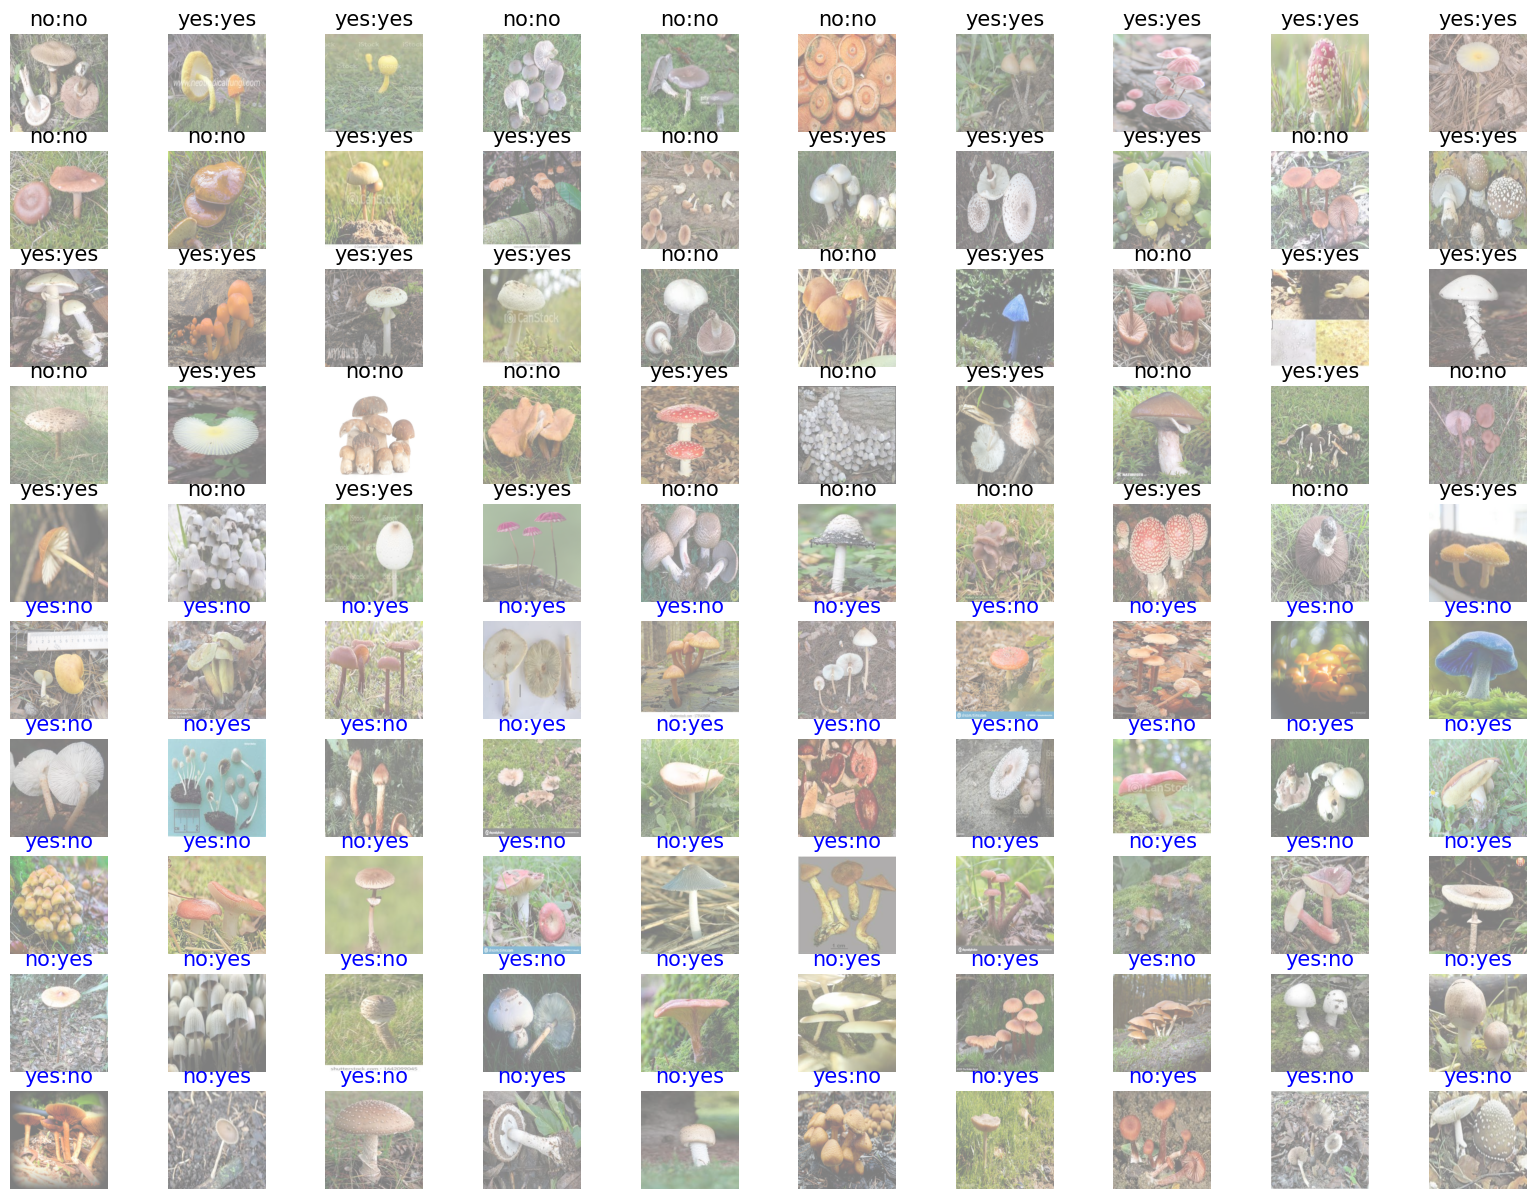

In [ ]:
# 乱数初期化
torch_seed()


test_loader2 = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)

**モデルの保存**

In [ ]:
# エラー防止のため一旦CPUにモデルを移動
net.cpu()

# パラメータ保存
netparam_path =  "net.prm"
torch.save(net.state_dict(), netparam_path)


## オプション

品種ごとに分類可能な識別器を作成しましょう。

結果は、上記の課題と同様に表示してください。

    

In [ ]:
# クラスラベル　大文字で始まる品種名は「ネコ」小文字は「イヌ」
classes = [ 'Abyssinian',
'american_bulldog',
'american_pit_bull_terrier',
'basset_hound',
'beagle',
'Bengal',
'Birman',
'Bombay',
'boxer',
'British_Shorthair',
'chihuahua',
'Egyptian_Mau',
'english_cocker_spaniel',
'english_setter',
'german_shorthaired',
'great_pyrenees',
'havanese',
'japanese_chin',
'keeshond',
'leonberger',
'Maine_Coon',
'miniature_pinscher',
'newfoundland',
'Persian',
'pomeranian',
'pug',
'Ragdoll',
'Russian_Blue',
'saint_bernard',
'samoyed',
'scottish_terrier',
'shiba_inu',
'Siamese',
'Sphynx',
'staffordshire_bull_terrier',
'wheaten_terrier',
'yorkshire_terrier' ]
